In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dataset=np.load("data/global_domain_float16_all.npy")[:]

In [9]:
dataset.shape

(1000, 3, 128, 64, 128)

In [10]:
def flip_dataset(data):
    axes_combinations = [
        (),  # No flip (original)
        (2,),  # x-axis (depth)
        (3,),  # y-axis (height)
        (4,),  # z-axis (width)
        (2, 3),  # xy-plane
        (2, 4),  # xz-plane
        (3, 4),  # yz-plane
        (2, 3, 4)  # xyz
    ]
    flipped_datasets = [np.flip(data, axis=axes) for axes in axes_combinations]
    return flipped_datasets

# Create two datasets with a stride of 2
stride_1 = dataset[::2]  # t0, t2, t4, ...
stride_2 = dataset[1::2]  # t1, t3, t5, ...

# Combine the original and stride datasets
all_datasets = [dataset, stride_1, stride_2]

# Apply flipping to all datasets
augmented_datasets = []
for data in all_datasets:
    augmented_datasets.extend(flip_dataset(data))


In [6]:
for i, data in enumerate(augmented_datasets):
    print(data.dtype)

float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16


In [11]:
import os
os.makedirs("data/augmented", exist_ok=True)
for i, data in enumerate(augmented_datasets):
    np.save(f"data/augmented/augmented_dataset_{i}", data)

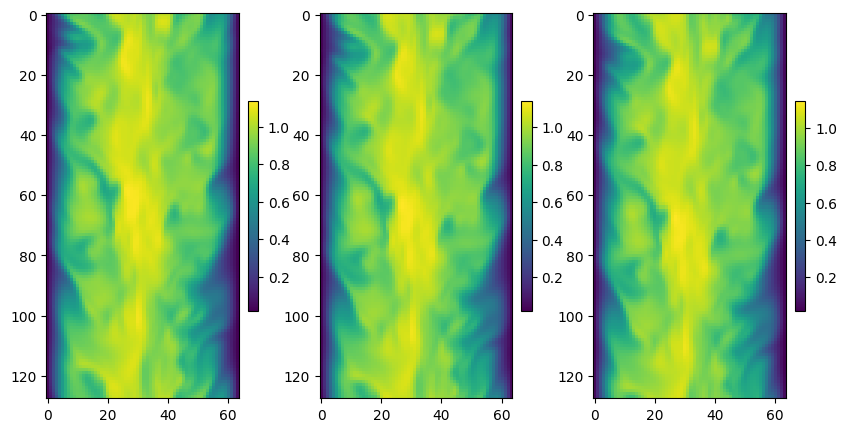

In [28]:
def plot_input_target_pred(dataset: np.ndarray, start=0, stride=20):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    im0 = axes[0].imshow(dataset[start, 0, :, :, 50], cmap="viridis")
    im1 = axes[1].imshow(dataset[start + stride, 0, :, :, 50], cmap="viridis")
    im2 = axes[2].imshow(dataset[start + 2 * stride, 0, :, :, 50], cmap="viridis")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    plt.show()


plot_input_target_pred(dataset)

In [24]:
model._num_parameters()

18407395

# msnist moving dataset

In [19]:
import numpy as np
data=np.load(r"C:\Users\Leonard\Documents\Python_projects\G-LED-Leo\Video_diffusion_github\VPTR\dataset\mnist_test_seq.npy")

In [20]:
data.shape

(20, 10000, 64, 64)

In [25]:
import numpy as np
data=[]
for i in range(5):
    data.append(np.load(f"data/mnist/mnist_1d64_{i}.npz", allow_pickle=True)["arr_0"])

In [67]:
data_full=np.concatenate(data, axis=0)
data_full=np.rot90(np.flip(data_full.reshape(20,-1,64,64, order="F"), axis=2),k=3, axes=(2,3))
data_full.shape

(20, 50000, 64, 64)

Video saved as mnist_moving_sequence/mnist_moving_sequence_0.mp4
Video saved as mnist_moving_sequence/mnist_moving_sequence_1.mp4
Video saved as mnist_moving_sequence/mnist_moving_sequence_2.mp4
Video saved as mnist_moving_sequence/mnist_moving_sequence_3.mp4


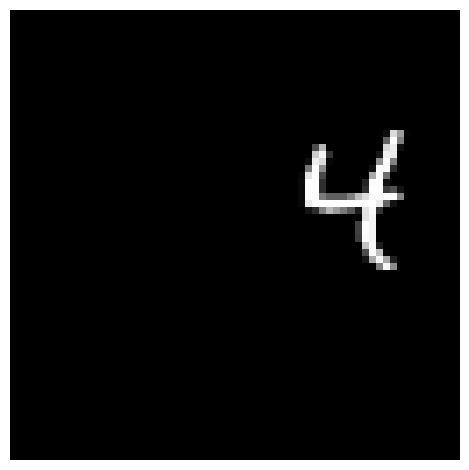

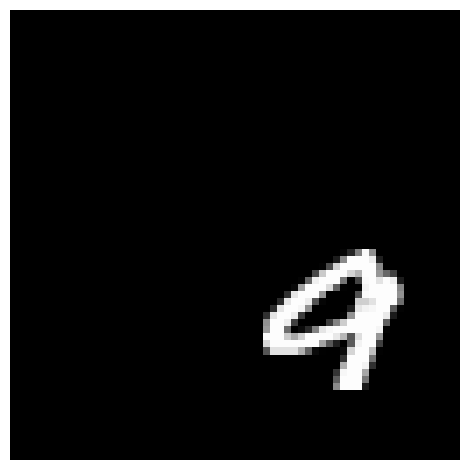

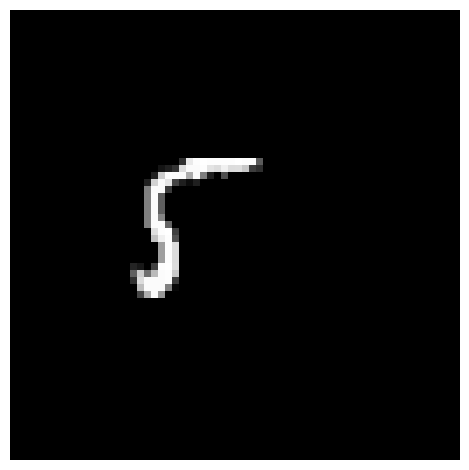

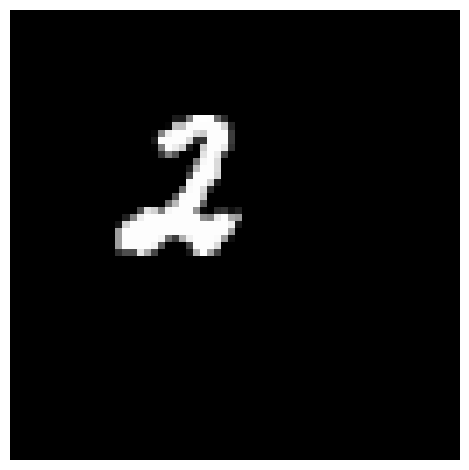

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import os
os.makedirs("mnist_moving_sequence", exist_ok=True)

# Select a sequence and sample frames
for sequence_index in range(4):  # Select the first sequence
    frames = data_full[:, sequence_index]  # Sample first 300 frames for the video

    # Create the video
    fig, ax = plt.subplots()
    image = ax.imshow(frames[0], cmap="gray", vmin=0, vmax=255)
    ax.axis("off")
    fig.tight_layout()

    # Configure the video writer
    writer = FFMpegWriter(fps=10, metadata=dict(artist="Matplotlib"), bitrate=1800)
    video_filename = f"mnist_moving_sequence/mnist_moving_sequence_{sequence_index}.mp4"

    # Create the animation
    with writer.saving(fig, video_filename, dpi=100):
        for frame in frames:
            image.set_data(frame)
            writer.grab_frame()

    print(f"Video saved as {video_filename}")


# Bubble dataset

In [300]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
flows=[]
for _ in range(2):
    # Parameters
    timesteps = 1000
    grid_size = 13  # Smaller size for better performance in 3D
    num_bubbles = 1
    min_radius, max_radius = 3, 3  # Minimum and maximum bubble radii
    blur_sigma = 2  # Standard deviation for Gaussian blur

    # Initialize bubble positions and directions in 3D
    bubble_positions = np.random.uniform(0, grid_size, (num_bubbles, 3))
    bubble_directions = np.random.normal(0, 1, (num_bubbles, 3))
    bubble_directions = bubble_directions / np.linalg.norm(
        bubble_directions, axis=1, keepdims=True
    )

    # Initialize random velocities for each bubble
    bubble_velocities = np.random.uniform(1, 2, (num_bubbles, 1))
    bubble_directions *= bubble_velocities  # Scale directions by velocity

    # Initialize bubble radii and growth parameters
    bubble_sizes = np.random.uniform(min_radius, max_radius, num_bubbles)
    bubble_growth_directions = np.random.choice([-1, 1], num_bubbles)
    bubble_growth_rates = np.random.uniform(0.5, 1, num_bubbles)

    # Initialize 3D flow
    flow = np.zeros((timesteps, grid_size, grid_size, grid_size), dtype=np.int8)

    # Simulate the flow
    for t in tqdm(range(timesteps)):
        # Clear grid
        grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int8)

        # Update bubble positions and enforce periodic boundary conditions
        bubble_positions += bubble_directions
        bubble_positions %= grid_size

        # Update bubble sizes
        # for i in range(num_bubbles):
        #     bubble_sizes[i] += bubble_growth_directions[i] * bubble_growth_rates[i]
        #     if bubble_sizes[i] >= max_radius or bubble_sizes[i] <= min_radius:
        #         bubble_growth_directions[i] *= -1  # Reverse growth direction

        # Draw bubbles in the grid
        for i, pos in enumerate(bubble_positions):
            x, y, z = np.round(pos).astype(int)
            radius = int(bubble_sizes[i])
            for dx in range(-radius, radius + 1):
                for dy in range(-radius, radius + 1):
                    for dz in range(-radius, radius + 1):
                        if dx**2 + dy**2 + dz**2 <= radius**2:
                            nx, ny, nz = (x + dx) % grid_size, (y + dy) % grid_size, (z + dz) % grid_size
                            grid[nx, ny, nz] = 1


        # Save grid to flow
        flow[t] = grid
    flow = gaussian_filter(flow.astype(np.float32), sigma=0.4, axes=(1,2,3))
    flows.append(flow)
flow=np.stack(flows, axis=1)


100%|██████████| 1000/1000 [00:00<00:00, 8887.03it/s]


In [301]:
flow.shape


(1000, 2, 13, 13, 13)

In [149]:
np.save("data/3d_bubble_flow.npy", flow)
flow.dtype

dtype('int8')

In [10]:
flow.max()

1.0

In [190]:
i=0

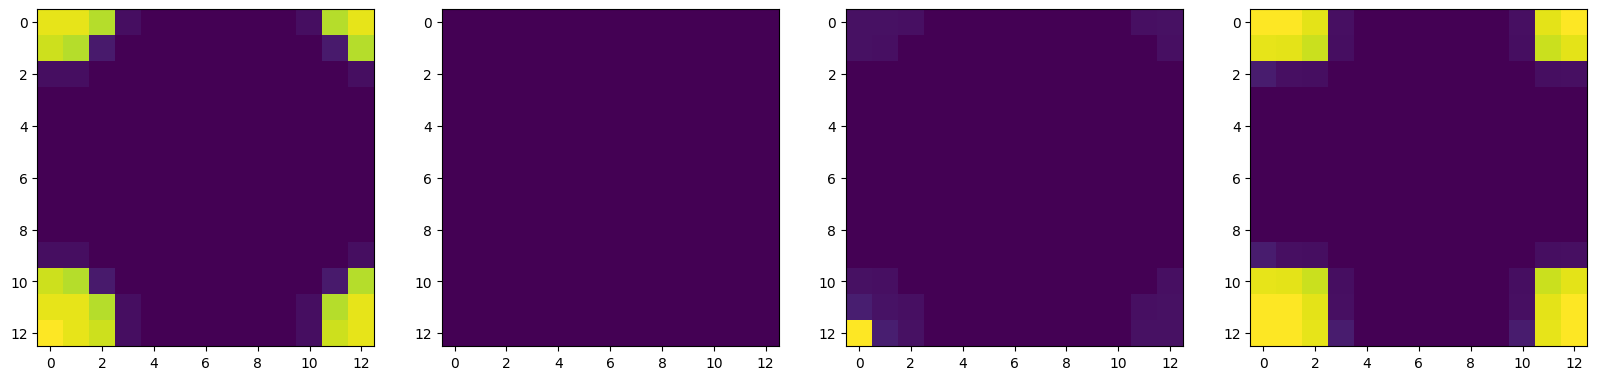

In [315]:
i+=1
fig, axes = plt.subplots(1,4, figsize=(20, 5))
im0 = axes[0].imshow(flow[i,0,:, :, 0], cmap="viridis")
im0 = axes[1].imshow(flow[i,0,:, :, 4], cmap="viridis")
im0 = axes[2].imshow(flow[i,0,:, :, 8], cmap="viridis")
im0 = axes[3].imshow(flow[i,0,:, :, 12], cmap="viridis")

In [316]:

# Create a 3D visualization of the 3D flow
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 1, 1])

# Set fixed bounds for the plot
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_zlim(0, grid_size)

# Initial frame
def plot_frame(frame, ax):
    ax.clear()
    ax.set_title(f"3D Flow Simulation: Timestep {frame}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Set fixed bounds for consistency
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_zlim(0, grid_size)

    # Extract 3D grid for this timestep
    grid = flow[frame, 0]
    x, y, z = np.nonzero(grid > 0.5)

    # Plot the points
    ax.scatter(x, y, z, c=grid[x, y, z], cmap="viridis", marker="o", alpha=0.8)

# Animation function
def update(frame):
    plot_frame(frame, ax)
    return [ax]

timesteps=100
ani = FuncAnimation(fig, update, frames=timesteps, interval=100, blit=False)
video_path = "3d_flow_simulation.mp4"
ani.save(video_path, writer="ffmpeg", fps=4)
plt.close(fig)

print(f"3D video with variable bubble radius saved at: {video_path}")


3D video with variable bubble radius saved at: 3d_flow_simulation.mp4


## 2D

In [320]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter

# Parameters
timesteps = 100
grid_size = 13
bubble_radius = 2
num_bubbles = 1
angle_variance = np.deg2rad([-45, -40, -35, -30, -25, -20, 20, 25, 30, 35, 40, 45])
blur_sigma = 1 # Standard deviation for Gaussian blur

# Initialize bubble positions and directions
bubble_positions = np.random.uniform(0, grid_size, (num_bubbles, 2))
bubble_directions = np.array(
    [
        [
            1,
            np.tan(np.random.choice(angle_variance)),
        ]
        for _ in range(num_bubbles)
    ]
)
bubble_directions = bubble_directions / np.linalg.norm(
    bubble_directions, axis=1, keepdims=True
)

# Initialize random velocities for each bubble
bubble_velocities = np.random.uniform(1, 3, (num_bubbles, 1))
bubble_directions *= bubble_velocities  # Scale directions by velocity

# Initialize 2D flow
flow = np.zeros((timesteps, grid_size, grid_size))

# Simulate the flow
for t in range(timesteps):
    # Clear grid
    grid = np.zeros((grid_size, grid_size))

    # Update bubble positions and enforce periodic boundary conditions
    bubble_positions += bubble_directions
    bubble_positions %= grid_size

    # Draw bubbles in the grid
    for pos in bubble_positions:
        x, y = np.round(pos).astype(int)
        for dx in range(-bubble_radius, bubble_radius + 1):
            for dy in range(-bubble_radius, bubble_radius + 1):
                if dx**2 + dy**2 <= bubble_radius**2:
                    nx, ny = (x + dx) % grid_size, (y + dy) % grid_size
                    grid[nx, ny] = 1

    # Apply Gaussian blur
    grid = gaussian_filter(grid, sigma=blur_sigma)

    # Save grid to flow
    flow[t] = grid

# Create a video of the 2D flow
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(flow[0], cmap="viridis", interpolation="nearest")
ax.set_title("2D Flow Simulation with Gaussian Blur")


def update(t):
    im.set_array(flow[t])
    ax.set_title(f"Timestep: {t}")
    return [im]


ani = FuncAnimation(fig, update, frames=timesteps, interval=100, blit=True)
video_path = "2d_flow_simulation_with_blur.mp4"
ani.save(video_path, writer="ffmpeg", fps=5)
plt.close(fig)

print(f"Video saved at: {video_path}")

Video saved at: 2d_flow_simulation_with_blur.mp4


# Resplit data mesh3

In [1]:
import glob
import numpy as np
import os

os.makedirs("data/global_domain_float16_double", exist_ok=True)

files = sorted(glob.glob("data/global_domain_float16/*.npy"))

for i in range(0, len(files)-1, 2):
    if i + 1 < len(files):
        array1 = np.load(files[i], mmap_mode="r")
        array2 = np.load(files[i + 1], mmap_mode="r")
        
        stacked_array = np.concatenate((array1, array2), axis=0)
        
        output_file = os.path.join(
            "data/global_domain_float16_double", f"stacked_{i // 2}.npy"
        )
        np.save(output_file, stacked_array)
        print(f"Saved stacked file: {output_file}")

print("All files stacked and saved.")


Saved stacked file: data/global_domain_float16_double\stacked_0.npy
Saved stacked file: data/global_domain_float16_double\stacked_1.npy
Saved stacked file: data/global_domain_float16_double\stacked_2.npy
Saved stacked file: data/global_domain_float16_double\stacked_3.npy
Saved stacked file: data/global_domain_float16_double\stacked_4.npy
All files stacked and saved.


In [2]:
stacked_array.shape

(2, 519, 3, 128, 64, 128)